# Soccer Analysis - Portuguese League example

Many people watch soccer games, however, it is never clear which part is the result of a team's merit or just a fruit of chance.

Questions like: 

* What is the probability of a team winning against another?
* In which position would a Portuguese team be if it played in another league?
* What is the chance of a team winning the league?

May have an answer through mathematical analysis.

I addressed these and other questions through statistical modeling.
A statistical model is a class of mathematical model that embodies several assumptions, derived from the nature of the problem, and give rise to a family of statistical models with unknown parameters, which will be determined to adjust to a training set.

Based on the probability distribution obtained it will be possible to measure the likelihood of a given event to happen.

## Objectives
* **Descriptive Data Visualization** - sketch out the main figures of the season.
* **Statistical Modeling**:
 * Obtain a *Offensive and Defensive Score per Team*
 * Determine the *advantage of playing at home* - is it statistical significant?
 * Determine the *Rank and Scores at the end of the season Probability distributions* - for example, to measure the chances of a team winning the league.

### 0.1 Data Extraction
We will extact data from the website http://www.football-data.co.uk/data.php that provides free historical data of Portuguese Football League

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("http://www.football-data.co.uk/mmz4281/1516/P1.csv", engine='python', skipfooter=1)

Extracted data have the following form:

In [2]:
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,P1,14/08/15,Tondela,Sp Lisbon,1,2,A,0,1,A,...,1.77,24.0,1.50,2.02,1.94,1.95,1.89,15.00,5.83,1.27
1,P1,15/08/15,Belenenses,Rio Ave,3,3,D,1,1,D,...,1.52,23.0,0.00,1.80,1.73,2.20,2.10,2.29,3.11,3.74
2,P1,15/08/15,Porto,Guimaraes,3,0,H,1,0,H,...,2.17,24.0,-2.00,2.00,1.94,1.95,1.88,1.19,7.19,22.21
3,P1,16/08/15,Benfica,Estoril,4,0,H,0,0,D,...,2.06,25.0,-1.25,1.75,1.69,2.28,2.15,1.32,5.45,11.89
4,P1,16/08/15,Moreirense,Arouca,0,2,A,0,0,D,...,1.52,23.0,-0.25,2.00,1.94,1.94,1.88,2.32,3.34,3.37


### 0.2 Data Manipulation
Desired data format:
 * Round
 * Team1
 * Team2
 * Goals1 (Goals scored by Team1)
 * Goals2 (Goals scored by Team2)
 * Home (+1 if Team1 plays and home, -1 otherwise)


In [3]:
home = df[[2, 3, 4, 5]].copy() #selecting revelant columns
home.columns = ['Team1', 'Team2', 'Goals1', 'Goals2'] # renaming columns
home['Home'] = 1
away = df[[3,2,5,4]].copy()
away.columns = ['Team1', 'Team2', 'Goals1', 'Goals2']
away['Home'] = -1
matches = pd.concat([home, away]).sort_index() # we use sort_index to sort games by their order
matches['Round'] = matches.groupby('Team1').cumcount() + 1
matches = matches[['Round', 'Team1', 'Team2', 'Home', 'Goals1', 'Goals2']]  # reorder columns
# points that Team1 got in a given match
matches['Points'] = 3 * (matches['Goals1'] > matches['Goals2']) + (matches['Goals1'] == matches['Goals2'])

# cumulative score over the season
matches['Score'] = matches.groupby('Team1')['Points'].cumsum()

# list of teams, sorted by rank at the final of the season
teams = matches[matches['Round'] == matches['Round'].max()].sort_values('Score', ascending=False)['Team1']

# 1 Data Visualization

## 1.1 Scored and Conceded Goals per Team

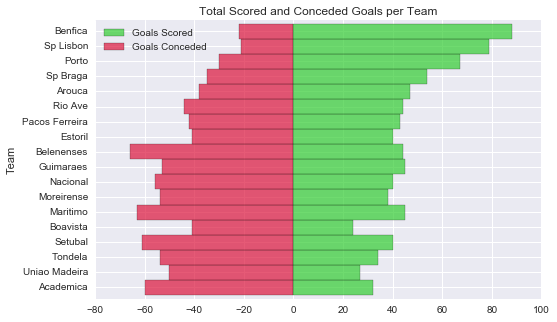

In [6]:
# importing visualization packages
%matplotlib inline
from matplotlib import pyplot
import seaborn as sb; sb.set()

# total goals scored and conceded per team
total_goals = matches.groupby('Team1')['Goals1', 'Goals2'].sum()
total_goals = total_goals.loc[teams][::-1]
total_goals.columns = ['Goals Scored', 'Goals Conceded']
total_goals['Goals Conceded'] *= -1

pyplot.style.use('seaborn-deep')
total_goals.plot.barh(figsize=(8,5), stacked=True, width=1.0, color=['limegreen', 'crimson'], alpha=.7)
pyplot.title("Total Scored and Conceded Goals per Team")
pyplot.ylabel("Team")

## 1.2 Score per Team over the Season

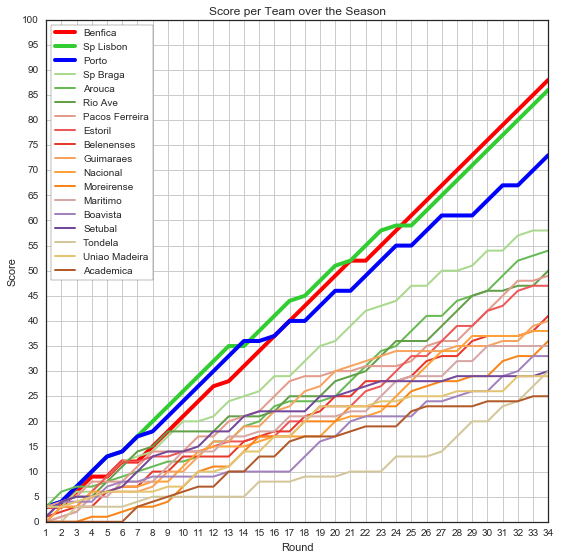

In [7]:
score = matches.set_index(['Round', 'Team1'])['Score'].unstack('Team1')[teams]

pyplot.style.use('seaborn-white')
ax = score.plot.line(lw=2, colormap='Paired', figsize=(9,9), style='-')
pyplot.ylabel("Score")
pyplot.xlabel("Round")
pyplot.title("Score per Team over the Season")
ax.lines[0].set_color('red')
ax.lines[1].set_color('limegreen')
ax.lines[2].set_color('blue')
ax.lines[0].set_linewidth(4)
ax.lines[1].set_linewidth(4)
ax.lines[2].set_linewidth(4)
pyplot.legend(loc='upper left', frameon=True)
pyplot.xticks(np.arange(2*17)+1)
pyplot.yticks(range(0,2*3*17,5))
pyplot.grid(True)

## 1.3 Goal Difference per Game

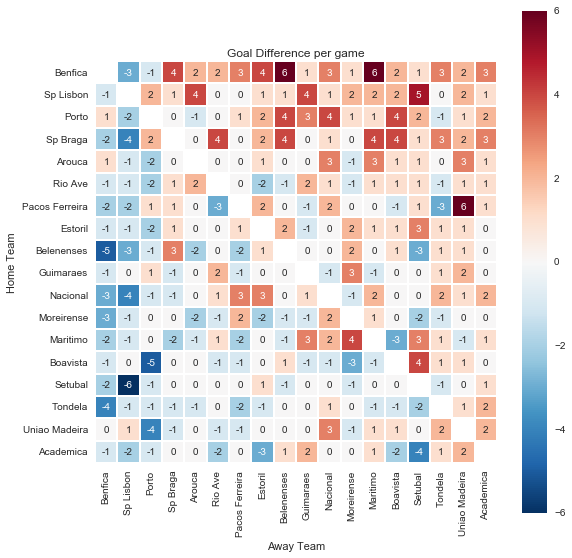

In [8]:
# creating a new column with goal difference
matches['diff'] = matches['Goals1'] - matches['Goals2']

# reformat the data in order to have lines corresponding the to home team, columns to the visiting team
# and the body with goal difference
data_map = matches[matches['Home']==1].set_index(['Team1', 'Team2'])['diff'].unstack(-1)
data_map = data_map.loc[teams][teams]  # reordering teams

pyplot.subplots(figsize=(9, 9))
pyplot.title("Goal Difference per game")
sb.heatmap(data_map, square=True, linewidths=1, annot=True, annot_kws={"size": 10})
pyplot.ylabel("Home Team")
pyplot.xlabel("Away Team")

# 2 Statistical Modeling

## 2.1 The Model

We assume that goals scored by one team agains other follows a poisson distribution, with a parameter $y_{ijk}$ where $ijk$ are the free variables that indicates the teams playing and if the game is played at home $(k=1)$ or away $(k=-1)$ (regarding Team1)

$$X_{ijk}\sim \mathrm{Poisson}\left(y_{ijk}\right)$$

Besides that, we assume that the function $y_{ijk} := y(i,j,k)$ is factorizable, that is:

$$ y_{ijk} = A(i)\cdot B(j)\cdot H(k)$$

Since we want $A$, $B$ and $H$ positive, and $H(-1)=H(1)^{-1}$ we can rewrite:

$$A(i)=e^{a_i} \quad B(j) = e^{-b_j} \quad H(k)=e^{k\cdot h}$$

Since there is an invariance of results if we add a given value to all $a$'s and $b$'s equally, we force $A+B = 0$ where $A=\sum_i a_i$ and $B=\sum_i b_i$

Hence, we put: $y_{ijk} = \exp{\left(a_i-b_j+k\cdot h\right)}$

To summarize, we suppose that the goals that a team $i$ score against another team $j$ will depend on:
* The *atack score* of team $i$: $a_i$
* The *defensive score* of team $j$: $b_j$
* If the team $i$ plays at home ($k=1$) or not ($k=-1$)

## 2.2 Naive Approximation
To get a firt estimate for $a_i$, $b_j$ and $h$ parameters we use the following approximations:

$$e^h + e^{-h} \simeq 2$$ and $$\sum_j \exp{b_j} \simeq N \exp{\frac{\sum_j b_j}{N}}$$

Application:

For a fixed $i$:
$$\frac{1}{2(N-1)}\sum_{k}\sum_{j\neq i} x_{ijk} \simeq \frac{1}{2(N-1)}\sum_{k}\sum_{j\neq i} e^{ a_i-b_j+k\cdot h} \simeq \frac{1}{N-1}\sum_{j\neq i} e^{ a_i-b_j} \simeq e^{a_i - \frac{1}{N-1}(B - b_i)} \ \ \ \ (1)$$

Then, summing accross all $i$'s:

$\bar x = \frac{1}{2N(N-1)}\sum_{k}\sum_i\sum_{j\neq i} x_{ijk} ~ \frac{1}{N} \sum_i e^{a_i - \frac{1}{N-1}(B - b_i)} \simeq e^{\frac{1}{N}A - \frac{1}{N-1}B + \frac{1}{N(N-1)}B} = e^{\frac{2}{N}A}$

Hence, $A \simeq \frac{1}{2N} \ln \bar x$


Applying the logarithm to equation (1) (and a similar equation with the sum across al the $a_i$'s) we get:

$\begin{cases}
a_i + \frac{1}{N-1}b_i \simeq \ln \bar x_{i\_} - \frac{N}{2(N-1)} \ln \bar x\\
b_i + \frac{1}{N-1}a_i \simeq \frac{N}{2(N-1)} \ln \bar x - \ln \bar x_{\_i}\\
\end{cases}
\implies\begin{cases}
a_i \simeq \frac{(N-1)^2}{N(N-2)}\ln \bar x_{i\_} + \frac{N-1}{N(N-2)} \ln \bar x_{\_i} - \frac{N}{2(N-2)}\ln \bar x\\
b_i \simeq  \frac{N}{2(N-2)}\ln \bar x - \frac{N-1}{N(N-2)} \ln \bar x_{\_i} - \frac{(N-1)^2}{N(N-2)} \ln \bar x_{i\_}\\
\end{cases}$

where $\bar x_{i\_}$ and $\bar x_{\_i}$ are the average goals scored and conceded by a team respectively.

In [9]:
# initial guess
a = matches.groupby('Team1')['Goals1'].mean().map(np.log) - np.log(matches['Goals1'].mean())/2
b = np.log(matches['Goals2'].mean())/2 - matches.groupby('Team1')['Goals2'].mean().map(np.log)
xi_ = matches.groupby('Team1')['Goals1'].mean().map(np.log)
x_i = matches.groupby('Team1')['Goals2'].mean().map(np.log)
x_ = np.log(matches['Goals1'].mean())
n = teams.size
a = (((n-1)**2)/float(n*(n-2)) * xi_ + ((n-1)/float(n*(n-2))) * x_i - n/float(2*(n-2)) * x_)
b = -(((n-1)**2)/float(n*(n-2)) * x_i + ((n-1)/float(n*(n-2))) * xi_ - n/float(2*(n-2)) * x_)
h = matches.groupby('Home')['Goals1'].sum().map(np.log).reset_index().prod(1).sum()/2

score = pd.DataFrame({'a':a, 'b':b}, index=teams) # naive-score
print score

                       a         b
Team1                             
Benfica         0.756515  0.552763
Sp Lisbon       0.645506  0.605813
Porto           0.501232  0.257625
Sp Braga        0.293874  0.115672
Arouca          0.159409  0.041343
Rio Ave         0.101876 -0.101876
Pacos Ferreira  0.076061 -0.053838
Estoril         0.002067 -0.025387
Belenenses      0.125810 -0.508749
Guimaraes       0.135412 -0.289951
Nacional        0.020470 -0.338250
Moreirense     -0.033148 -0.298728
Maritimo        0.145615 -0.463394
Boavista       -0.510533  0.004766
Setubal         0.025518 -0.424069
Tondela        -0.144760 -0.292163
Uniao Madeira  -0.380627 -0.201327
Academica      -0.199376 -0.394310


## 2.3 Maximum Log-Likelihood Estimation
Log-Likelihood function:
$$l\left(\theta\right)=\sum_{ijk} \sum_o \left(x_{ijk}^o \ln y_{ijk}(\theta) - y_{ijk}(\theta)\right) $$

## 2.4 Maxlike module

In [10]:
# load maxlike module for local drive
import sys
sys.path.insert(0, 'C:\\Users\\laptop\\GitHub\\maxlike')
import maxlike

In [11]:
_ = np.newaxis

def Y(I, coef):
    return I * np.exp(coef[0][:,_,_] - coef[1][_,:,_] + coef[2] * k[_,_,:])

I, X, axis = maxlike.series_to_ndarray(matches.set_index(['Team1', 'Team2', 'Home']).Goals1)
t, t, k = axis
mle = maxlike.poisson(I, X)
mle.set_coef([score.loc[t,'a'], score.loc[t, 'b'].values, np.array(h)])
_ = np.newaxis
mle.set_model(Y)

Besides the model itself, maxlike module needs the gradient and the hessian of the log-likelihood function as inputs.

* Gradient Calculation:
$$\frac{\partial l}{\partial a_i} = \sum_{jk} (x_{ijk} - y_{ijk})
\quad\quad
\frac{\partial l}{\partial b_j} = - \sum_{ik} (x_{ijk} - y_{ijk})
\quad\quad
\frac{\partial l}{\partial h} = \sum_{ijk} k\cdot(x_{ijk} - y_{ijk})$$

* Hessian Calculation:
$$\frac{\partial^2 l}{\partial a_i \partial a_j} = - \delta_{ij} \sum_{uk} y_{iuk}
\quad\quad
\frac{\partial^2 l}{\partial a_i \partial b_j} = \sum_{k} y_{ijk}
\quad\quad
\frac{\partial^2 l}{\partial a_i \partial h} = - \sum_{jk} k\cdot y_{ijk}$$
$$\frac{\partial^2 l}{\partial b_i \partial b_j} = - \delta_{ij} \sum_{uk} y_{ujk}
\quad\quad
\frac{\partial^2 l}{\partial b_j \partial h} = - \sum_{uk} y_{ujk}
\quad\quad
\frac{\partial^2 l}{\partial^2 h} = - \sum_{ijk} k^2\cdot y_{iuk}$$

In [12]:
def grad_L(I, X, Y, coef):
    D = X - Y
    return [
         D.sum((1,2)),
        -D.sum((0,2)),
        (D * k[_, _, :]).sum()]

def hess_L(I, X, Y, coef):
    return [
        [-np.diag(Y.sum((1,2)))],
        [Y.sum(2),
         -np.diag(Y.sum((0,2)))],
        [-(Y * k[_, _, :]).sum((1,2)),
          (Y * k[_, _, :]).sum((0,2)),
         -(Y * (k * k)[_, _, :]).sum()]]


mle.set_L(grad_L, hess_L)

Adding contraint: $\sum_i a_i + b_i = 0$

In [13]:
def g(args):
    return args[0].sum() + args[1].sum()

def grad_g(args):
    return map(lambda x: np.ones(x.size), args)

def hess_g(args):
    return [[np.zeros((args[0].size, args[0].size))],
            [np.zeros((args[0].size, args[1].size)),
             np.zeros((args[1].size, args[1].size))]]

mle.add_constraint([0,1], g, grad_g, hess_g)

Running the algorithm:

In [14]:
mle.run(max_steps=1000, e=0.00001)
coef = mle.coef
std_err = mle.std_error()

0 491.432664378
1 491.4105644
2 491.410563305


### 2.4.1 Attack and Defensive Scores

In [15]:
score.loc[t,'a'] = coef[0]
score.loc[t, 'std_a'] = std_err[0]
score.loc[t,'b'] = coef[1]
score.loc[t, 'std_b'] = std_err[1]
print score

                       a         b     std_a     std_b
Team1                                                 
Benfica         0.770551  0.540673  0.105713  0.208259
Sp Lisbon       0.661031  0.599068  0.111341  0.213109
Porto           0.507402  0.256814  0.120573  0.178670
Sp Braga        0.297420  0.118861  0.133905  0.165605
Arouca          0.161992  0.045295  0.143300  0.159042
Rio Ave         0.103474 -0.097931  0.148005  0.148005
Pacos Ferreira  0.077869 -0.049997  0.149681  0.151418
Estoril         0.004082 -0.022032  0.155084  0.153217
Belenenses      0.131995 -0.505016  0.148011  0.121461
Guimaraes       0.137593 -0.285977  0.146387  0.135135
Nacional        0.023234 -0.334787  0.155089  0.131555
Moreirense     -0.030814 -0.295717  0.159044  0.133907
Maritimo        0.150632 -0.459582  0.146391  0.124234
Boavista       -0.507765 -0.002042  0.199475  0.153212
Setubal         0.029709 -0.420643  0.155090  0.126194
Tondela        -0.142392 -0.290600  0.167983  0.133905
Uniao Made

### 2.4.2 Advantage of playing at home

In [43]:
h = coef[2]
std_h = std_err[2]
print "95% confidence interval for advantage of playing at home:"
print "[%.2f%%, %.2f%%]" % tuple(100*(np.exp(h + np.array([-1,+1])*1.96*std_h)-1))

95% confidence interval for advantage of playing at home:
[4.75%, 20.11%]


# 3 Simulation

We perfom a monte carlo simulation to predict the probability of some outcomes.

In [18]:
_ = np.newaxis
Y_test = np.exp(coef[0][:,_,_] - coef[1][_,:,_] + coef[2] * k[_,_,:])
N = 100000
X_test = np.random.poisson(np.multiply.outer(Y_test ,np.ones(N)))
X_test[np.arange(t.size), np.arange(t.size),:,:] = 0
# force the diagonal values to be zero - a team cannot play againts itself.
gd = X_test[:,:,1,:] - np.swapaxes(X_test[:,:,0,:],0,1)
score = (3.0*(gd>0) + 1.0*(gd==0)).sum(1) + (3.0*(gd<0) + 1.0*(gd==0)).sum(0)
pos = teams.size- score.argsort(0).argsort(0)

sim = pd.DataFrame(score.transpose(), index=range(N), columns=t)[teams]
pos = pd.DataFrame(pos.transpose(), index=range(N), columns=t)[teams]
sim_plot = pd.DataFrame(index=range(2*3*17))
pos_plot = pd.DataFrame(index=np.arange(teams.size)+1)
for team in teams.values:
    sim_plot[team] = (sim[team].values[:,None]==sim_plot.index.values[None,:]).sum(0)/float(N)
    pos_plot[team] = (pos[team].values[:,None]==pos_plot.index.values[None,:]).sum(0)/float(N)

## 3.1 Score at the end of the Season Distribution Curve 

Score at the end of the Season
                    mean       std   25%   50%   75%
Benfica         84.91833  5.661669  81.0  85.0  89.0
Sp Lisbon       82.62477  5.891811  79.0  83.0  87.0
Porto           71.65819  6.670177  67.0  72.0  76.0
Sp Braga        61.48447  7.062213  57.0  62.0  66.0
Arouca          55.12777  7.128365  50.0  55.0  60.0
Rio Ave         49.45268  7.139066  45.0  49.0  54.0
Pacos Ferreira  50.00865  7.148178  45.0  50.0  55.0
Estoril         48.52531  7.135265  44.0  48.0  53.0
Belenenses      38.16902  6.963276  33.0  38.0  43.0
Guimaraes       45.07580  7.120660  40.0  45.0  50.0
Nacional        40.21620  6.986523  35.0  40.0  45.0
Moreirense      39.84416  6.944641  35.0  40.0  44.0
Maritimo        40.16900  6.991295  35.0  40.0  45.0
Boavista        35.85646  6.565582  31.0  36.0  40.0
Setubal         37.80365  6.896332  33.0  38.0  42.0
Tondela         36.94908  6.806374  32.0  37.0  41.0
Uniao Madeira   33.56882  6.552941  29.0  33.0  38.0
Academica      

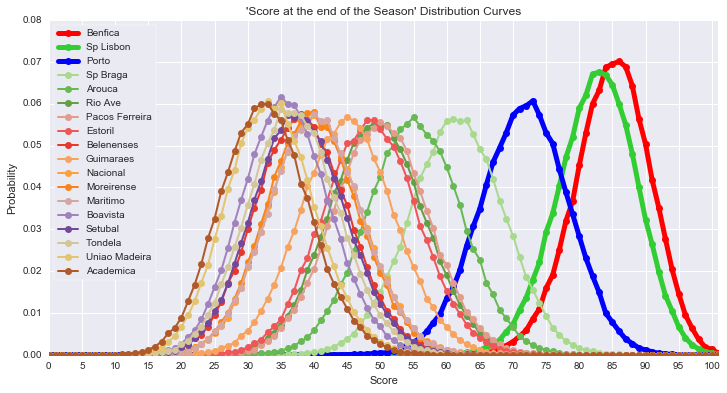

In [19]:
pyplot.style.use('seaborn-dark')
ax = sim_plot.plot.line(lw=2, colormap='Paired', figsize=(12,6), style='-o')
ax.lines[0].set_color('red')
ax.lines[1].set_color('limegreen')
ax.lines[2].set_color('blue')
ax.lines[0].set_linewidth(5)
ax.lines[1].set_linewidth(5)
ax.lines[2].set_linewidth(5)
pyplot.xticks(range(0,2*3*17,5))
pyplot.legend(loc='upper left', frameon=True)
pyplot.grid(True)
pyplot.title("'Score at the end of the Season' Distribution Curves")
pyplot.xlabel('Score')
pyplot.ylabel('Probability')
print "Score at the end of the Season"
print sim.describe().loc[['mean', 'std', '25%', '50%', '75%']].transpose()

## 3.2 Rank at the end of the Season Distribution Curve

Rank at the end of the Season
                    mean       std   25%   50%   75%
Benfica          1.48807  0.625509   1.0   1.0   2.0
Sp Lisbon        1.71815  0.661268   1.0   2.0   2.0
Porto            3.08654  0.822665   3.0   3.0   3.0
Sp Braga         4.55567  1.426051   4.0   4.0   5.0
Arouca           6.10268  2.145251   5.0   6.0   7.0
Rio Ave          7.96796  2.831500   6.0   7.0  10.0
Pacos Ferreira   7.79996  2.763306   6.0   7.0   9.0
Estoril          8.44439  2.921355   6.0   8.0  10.0
Belenenses      12.95486  3.263932  11.0  13.0  16.0
Guimaraes        9.87643  3.209776   7.0  10.0  12.0
Nacional        12.03166  3.341265   9.0  12.0  15.0
Moreirense      12.05253  3.385484   9.0  12.0  15.0
Maritimo        12.07232  3.304951  10.0  12.0  15.0
Boavista        14.04702  2.953309  12.0  15.0  16.0
Setubal         13.09348  3.314238  11.0  13.0  16.0
Tondela         13.53375  3.143279  11.0  14.0  16.0
Uniao Madeira   14.87115  2.864578  13.0  16.0  17.0
Academica       

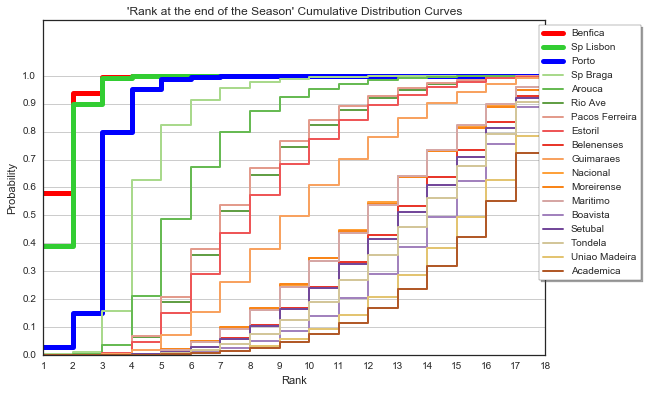

In [21]:
pyplot.style.use('seaborn-white')
ax = pos_plot.cumsum().plot.line(drawstyle="steps-post", lw=2, colormap='Paired', figsize=(9,6), style='-')
ax.lines[0].set_color('red')
ax.lines[1].set_color('limegreen')
ax.lines[2].set_color('blue')
ax.lines[0].set_linewidth(5)
ax.lines[1].set_linewidth(5)
ax.lines[2].set_linewidth(5)
legend = pyplot.legend(bbox_to_anchor=(1.2,1), ncol=1, frameon=True, shadow=True)
pyplot.xticks(np.arange(teams.size) + 1)
pyplot.yticks(np.arange(11)*.1)
pyplot.title("'Rank at the end of the Season' Cumulative Distribution Curves")
pyplot.xlabel('Rank')
pyplot.ylabel('Probability')
ax.yaxis.grid(True)
print "Rank at the end of the Season"
print pos.describe().loc[['mean', 'std', '25%', '50%', '75%']].transpose()
